<a href="https://colab.research.google.com/github/hcmute-toan/ML/blob/master/_downloads/cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [94]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [95]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



truck  ship truck  deer


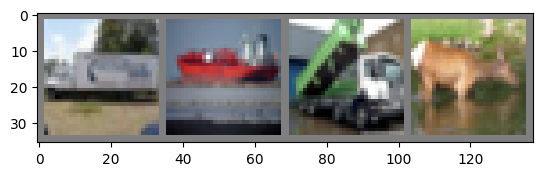

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        # Conv5x5 layers (10 layers)
        self.conv5_1 = nn.Conv2d(3, 32, 5, stride=1, padding=1)  # 32x30x30
        self.conv5_2 = nn.Conv2d(32, 32, 5, stride=1, padding=0)  # 32x26x26
        self.conv5_3 = nn.Conv2d(32, 64, 5, stride=1, padding=0)  # 64x22x22
        self.pool5_1 = nn.MaxPool2d(2, 2)  # 64x11x11
        self.conv5_4 = nn.Conv2d(64, 64, 5, stride=1, padding=2)  # 64x11x11
        self.conv5_5 = nn.Conv2d(64, 64, 5, stride=1, padding=2)  # 64x11x11
        self.conv5_6 = nn.Conv2d(128, 128, 5, stride=1, padding=2)  # 128x11x11
        self.conv5_7 = nn.Conv2d(128, 128, 5, stride=1, padding=2)  # 128x11x11
        self.conv5_8 = nn.Conv2d(128, 128, 5, stride=1, padding=2)  # 128x11x11
        self.conv5_9 = nn.Conv2d(128, 128, 5, stride=1, padding=1)  # 128x9x9
        self.conv5_10 = nn.Conv2d(128, 128, 5, stride=1, padding=1)  # 128x7x7
        # Conv3x3 layers (10 layers)
        self.conv3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)  # 256x7x7
        self.conv3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)  # 256x7x7
        self.pool3_1 = nn.MaxPool2d(2, 2)  # 256x3x3
        self.conv3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)  # 256x3x3
        self.conv3_4 = nn.Conv2d(256, 256, 3, stride=1, padding=1)  # 256x3x3
        self.conv3_5 = nn.Conv2d(512, 512, 3, stride=1, padding=1)  # 512x3x3
        self.conv3_6 = nn.Conv2d(512, 512, 3, stride=1, padding=1)  # 512x3x3
        self.conv3_7 = nn.Conv2d(512, 512, 3, stride=1, padding=1)  # 512x3x3
        self.conv3_8 = nn.Conv2d(512, 512, 3, stride=1, padding=1)  # 512x3x3
        self.conv3_9 = nn.Conv2d(512, 512, 3, stride=1, padding=0)  # 512x1x1
        self.conv3_10 = nn.Conv2d(512, 512, 3, stride=1, padding=1)  # 512x1x1
        # Fully connected layers
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv5_1(x))  # 32x30x30
        x = F.relu(self.conv5_2(x))  # 32x26x26
        x = F.relu(self.conv5_3(x))  # 64x22x22

        x = self.pool5_1(x)  # 64x11x11

        x1 = F.relu(self.conv5_4(x))  # 64x11x11
        x2 = F.relu(self.conv5_5(x))  # 64x11x11

        x = torch.cat((x1, x2), dim=1)  # 128x11x11

        x = F.relu(self.conv5_6(x))  # 128x11x11

        x1 = F.relu(self.conv5_7(x))  # 128x11x11

        x2 = F.relu(self.conv5_8(x))  # 128x11x11

        x = x1 + x2  # Residual connection

        x = F.relu(self.conv5_9(x))  # 128x9x9

        x = F.relu(self.conv5_10(x))  # 128x7x7


        x = F.relu(self.conv3_1(x))  # 256x7x7

        x = F.relu(self.conv3_2(x))  # 256x7x7

        x = self.pool3_1(x)  # 256x3x3

        x1 = F.relu(self.conv3_3(x))  # 256x3x3

        x2 = F.relu(self.conv3_4(x))  # 256x3x3

        x = torch.cat((x1, x2), dim=1)  # 512x3x3

        x = F.relu(self.conv3_5(x))  # 512x3x3

        x1 = F.relu(self.conv3_6(x))  # 512x3x3

        x2 = F.relu(self.conv3_7(x))  # 512x3x3

        x = x1 + x2  # Residual connection

        x = F.relu(self.conv3_8(x))  # 512x3x3


        x = F.relu(self.conv3_9(x))  # 512x1x1

        x = F.relu(self.conv3_10(x))  # 512x1x1



        x = x.view(x.size(0), -1)  # Flatten using x.size(0) to get batch size


        x = F.relu(self.fc1(x))

        x = self.fc2(x)  # Output: 10 classes

        return x

# Khởi tạo và in mô hình
net = Model3()
print("Model:")
if torch.cuda.is_available():
    net = net.cuda()
print(net)

# Hiển thị cấu trúc model với input size (3, 32, 32)
summary(net, (3, 32, 32))


Model:
Model3(
  (conv5_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv5_3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool5_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5_4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5_5): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5_6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5_7): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5_8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5_9): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv5_10): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3)

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [98]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [99]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.304
[1,  6000] loss: 2.304
[1,  8000] loss: 2.303
[1, 10000] loss: 2.303
[1, 12000] loss: 2.303
[2,  2000] loss: 2.304
[2,  4000] loss: 2.303
[2,  6000] loss: 2.303
[2,  8000] loss: 2.303
[2, 10000] loss: 2.304
[2, 12000] loss: 2.304
Finished Training


5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


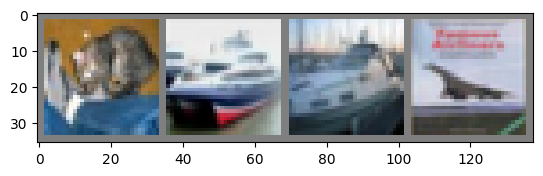

In [100]:
dataiter = iter(testloader)
images, labels = next(dataiter) # Use next(dataiter) instead of dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [101]:
images = images.cuda()
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [102]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  truck truck truck truck


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [103]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move images and labels to the same device as the model
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [104]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck : 100 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


